Send Help :(

In [273]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import view_plot
import math

In [274]:
# Checking and printing the current working directory
print(f"Current Working Directory: {os.getcwd()}")

# Define file path relative to the current working directory
data_file_path_x = "../utils/stepper_rotation_data/rotation_x.csv"
data_file_path_y = "../utils/stepper_rotation_data/rotation_y.csv"
data_file_path_z = "../utils/stepper_rotation_data/rotation_z.csv"
full_data_file_path_x = os.path.join(os.getcwd(), data_file_path_x)
full_data_file_path_y = os.path.join(os.getcwd(), data_file_path_y)
full_data_file_path_z = os.path.join(os.getcwd(), data_file_path_z)

# Checking if the path exists
if not os.path.exists(full_data_file_path_x):
    print(f"File not found: {full_data_file_path_x}")
elif not os.path.exists(full_data_file_path_y):
    print(f"File not found: {full_data_file_path_y}")
elif not os.path.exists(full_data_file_path_z):
    print(f"File not found: {full_data_file_path_z}")
else:
    print(f"Found file: {full_data_file_path_x}")
    print(f"Found file: {full_data_file_path_y}")
    print(f"Found file: {full_data_file_path_z}")

def read_csv(file_name):
    # Reading the CSV file
    sensor_data_df = pd.read_csv(file_name)

    # Assuming the dataframe includes columns 'Quaternion_W', 'Quaternion_X', 'Quaternion_Y', 'Quaternion_Z' for quaternions
    quaternion_data = sensor_data_df[['Quaternion_W', 'Quaternion_X', 'Quaternion_Y', 'Quaternion_Z']].values

    return quaternion_data

# Initialize and configure Unscented Kalman Filter (UKF)
dim_x = 4
dim_z = 4
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0.0)
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=lambda x, dt: x, hx=lambda x: x, dt=1/25, points=points)
ukf.x = np.array([1, 0, 0, 0])  # Initial state
ukf.P *= 0.1  # Initial covariance
    


Current Working Directory: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman
Found file: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman\../utils/stepper_rotation_data/rotation_x.csv
Found file: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman\../utils/stepper_rotation_data/rotation_y.csv
Found file: d:\SPAI_Lab\Project\HELIXON\RaD_team1_HELIXON\kalman\../utils/stepper_rotation_data/rotation_z.csv


In [280]:
def quaternion_to_euler_angles(q):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw) in radians.
    Quaternion format assumed as [w, x, y, z].
    """
    w, x, y, z = q
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    pitch = np.arcsin(sinp) if abs(sinp) <= 1 else np.pi / 2 * np.sign(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

def plot_euler_angles_over_time(quaternion_data_measured, quaternion_data_filtered ):
    # Initialize lists to store Euler angles over time
    rolls = []
    pitches = []
    yaws = []

    raw_rolls = []
    raw_pitches = []
    raw_yaws = []

    for q in quaternion_data_filtered:
        roll, pitch, yaw = quaternion_to_euler_angles(q)
        rolls.append(np.degrees(roll))
        pitches.append(np.degrees(pitch))
        yaws.append(np.degrees(yaw))

    for q in quaternion_data_measured:
        roll, pitch, yaw = quaternion_to_euler_angles(q)
        raw_rolls.append(np.degrees(roll))
        raw_pitches.append(np.degrees(pitch))
        raw_yaws.append(np.degrees(yaw))

    # Plotting Roll
    plt.figure(figsize=(10, 6))
    plt.plot(raw_rolls[15:], label='Measured Roll', color='m')
    plt.plot(rolls[15:], label='Filtered Roll', color='r')
    plt.title('Roll Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (°)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Pitch
    plt.figure(figsize=(10, 6))
    plt.plot(raw_pitches[15:], label='Measured Pitch', color='y')
    plt.plot(pitches[15:], label='Filtered Pitch', color='g')
    plt.title('Pitch Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (°)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting Yaw
    plt.figure(figsize=(10, 6))
    plt.plot(raw_yaws[15:], label='Measured Yaw', color='c')
    plt.plot(yaws[15:], label='Filtered Yaw', color='b')

    plt.title('Yaw Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Angle (°)')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_euler_angles_3d(quaternion_data, step):
    # Initialize lists to store Euler angles over time
    rolls = []
    pitches = []
    yaws = []

    for q in quaternion_data:
        roll, pitch, yaw = quaternion_to_euler_angles(q)
        rolls.append(roll)
        pitches.append(pitch)
        yaws.append(yaw)
    
    plot = view_plot.generate_plot(rolls,pitches,yaws,step)
    plot.show()


DATA X

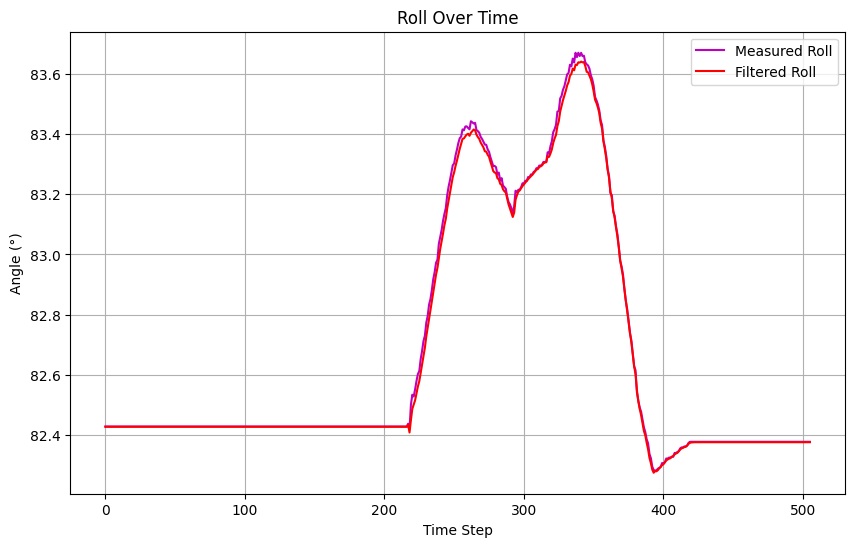

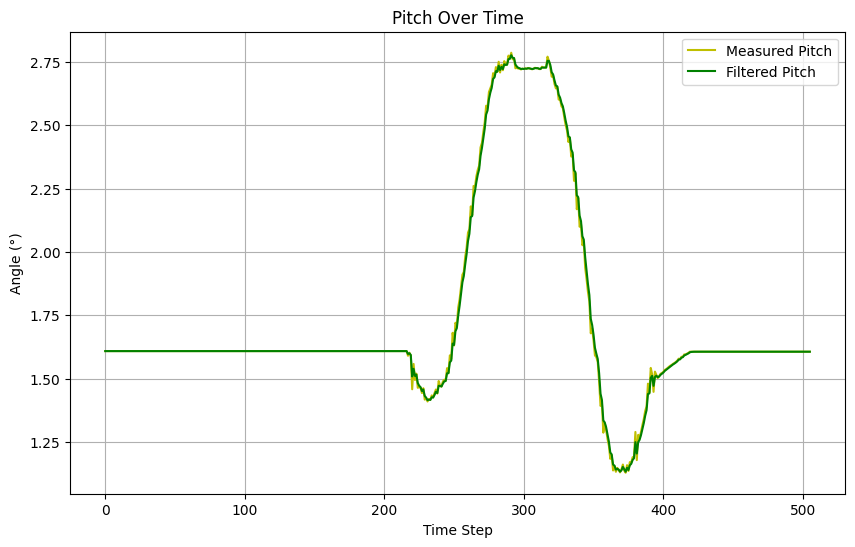

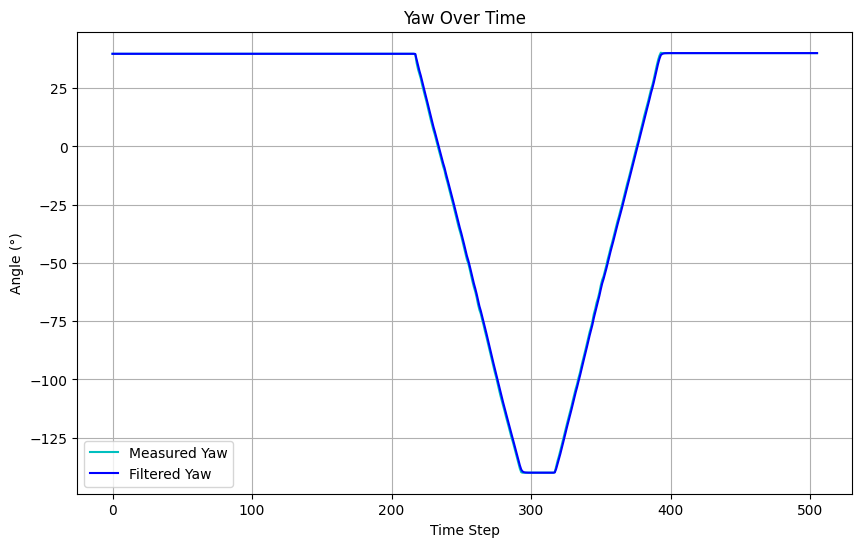

In [281]:
quaternion_data = read_csv(full_data_file_path_x)
# Predict states with UKF
predicted_states = []

for q in quaternion_data:
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    predicted_states.append(ukf.x)
predicted_states = np.array(predicted_states)

plot_euler_angles_3d(predicted_states,10)
plot_euler_angles_over_time(quaternion_data, predicted_states)
#slope starts at sample 232


DATA Y

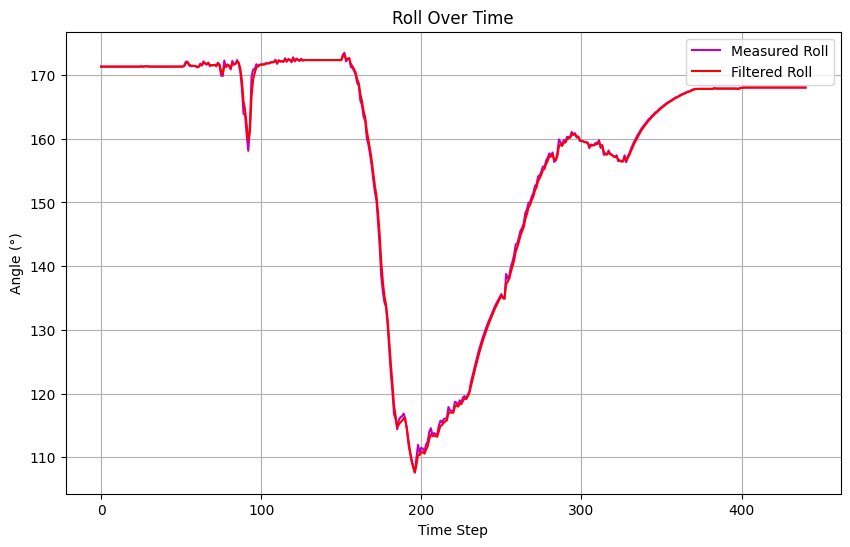

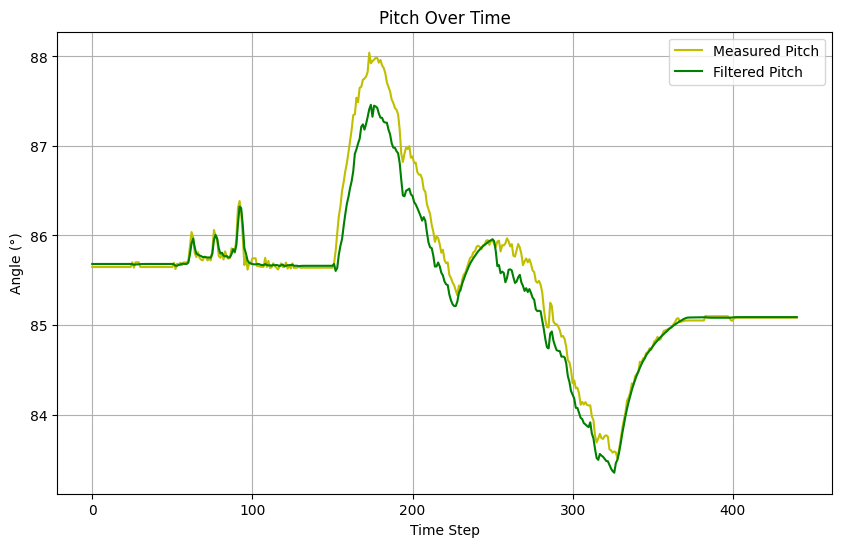

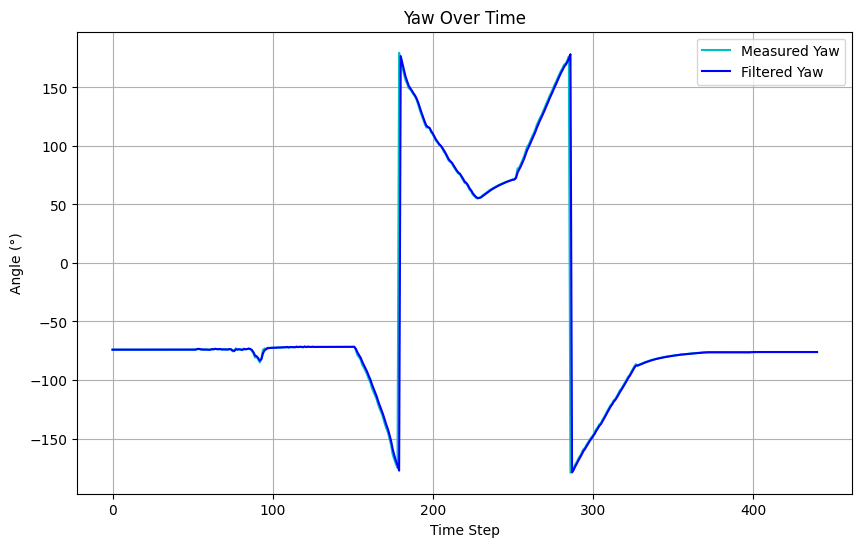

In [282]:

quaternion_data = read_csv(full_data_file_path_y)
# Predict states with UKF
predicted_states = []
for q in quaternion_data:
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    predicted_states.append(ukf.x)
predicted_states = np.array(predicted_states)

plot_euler_angles_3d(predicted_states,10)

plot_euler_angles_over_time(quaternion_data, predicted_states)

DATA Z

In [283]:

quaternion_data = read_csv(full_data_file_path_z)
# Predict states with UKF
predicted_states = []

for q in quaternion_data:
    q = q / np.linalg.norm(q)
    ukf.predict()
    ukf.update(q)
    predicted_states.append(ukf.x)
predicted_states = np.array(predicted_states)


plot_euler_angles_3d(predicted_states,10)



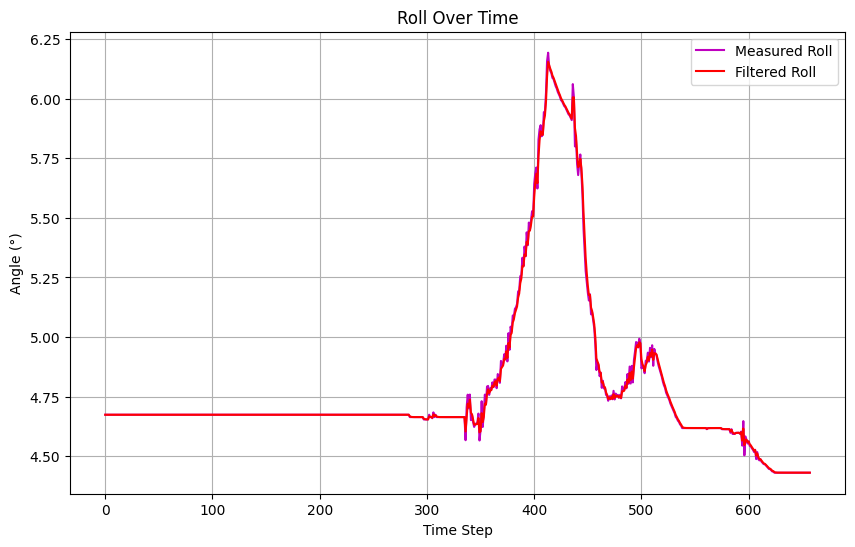

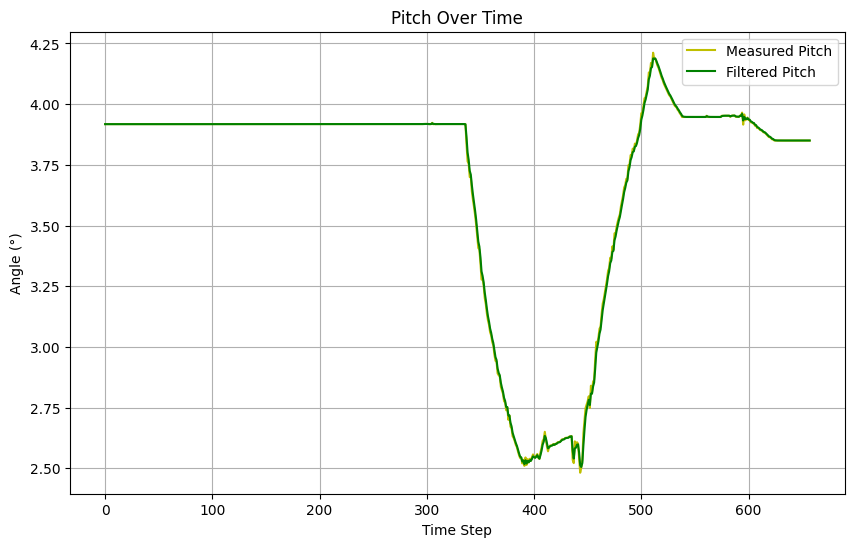

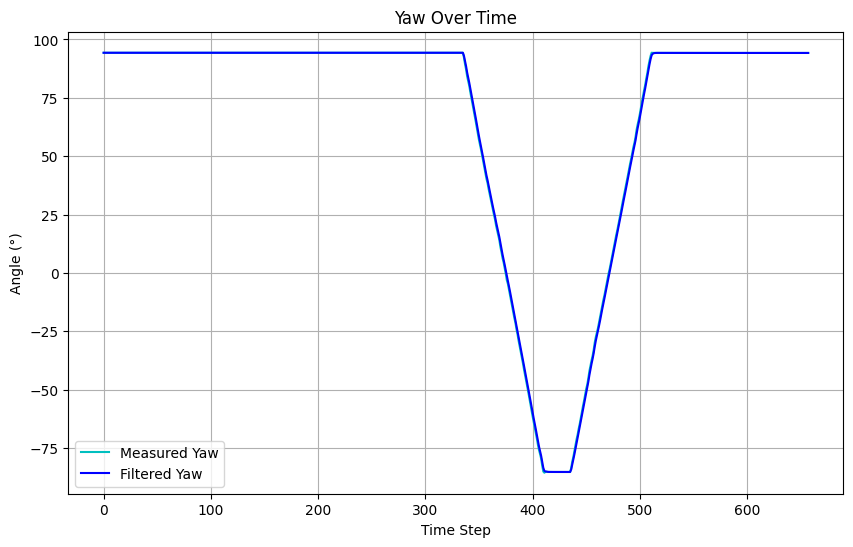

In [284]:

plot_euler_angles_over_time(quaternion_data, predicted_states)
# z_step starts at sample 136